# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [3]:
path = Path('C:/Users/jpatn/data/camvid_tira/')

In [5]:
image_path = path/'images'
label_path = path/'labels'
valid_path = path/'valid.txt'
weights    = Path('D:/programming/projects/camvid/models')

# Data

## Files

In [6]:
im_fp= get_image_files(image_path)

In [7]:
lbl_fp = get_image_files(label_path)

In [8]:
def open_im(fp):
    return PIL.Image.open(fp)

Image:

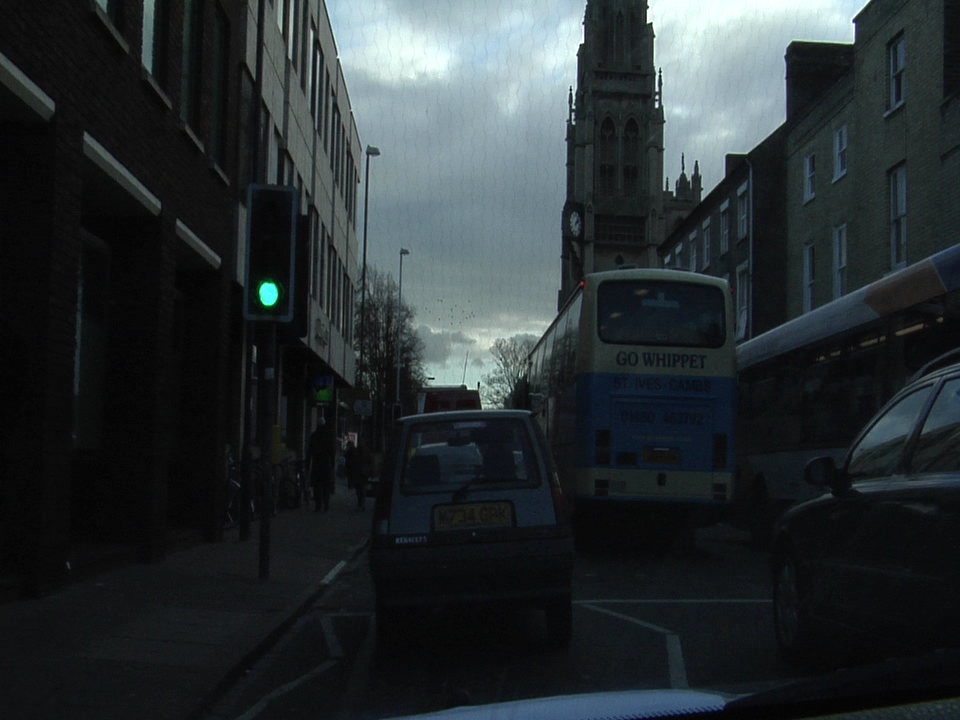

In [9]:
im1_fp = im_fp[0]
im1 = open_im(im1_fp); im1

In [10]:
get_lbl_fp = lambda x: label_path/f'{x.stem}_P{x.suffix}'

Label opened as image:

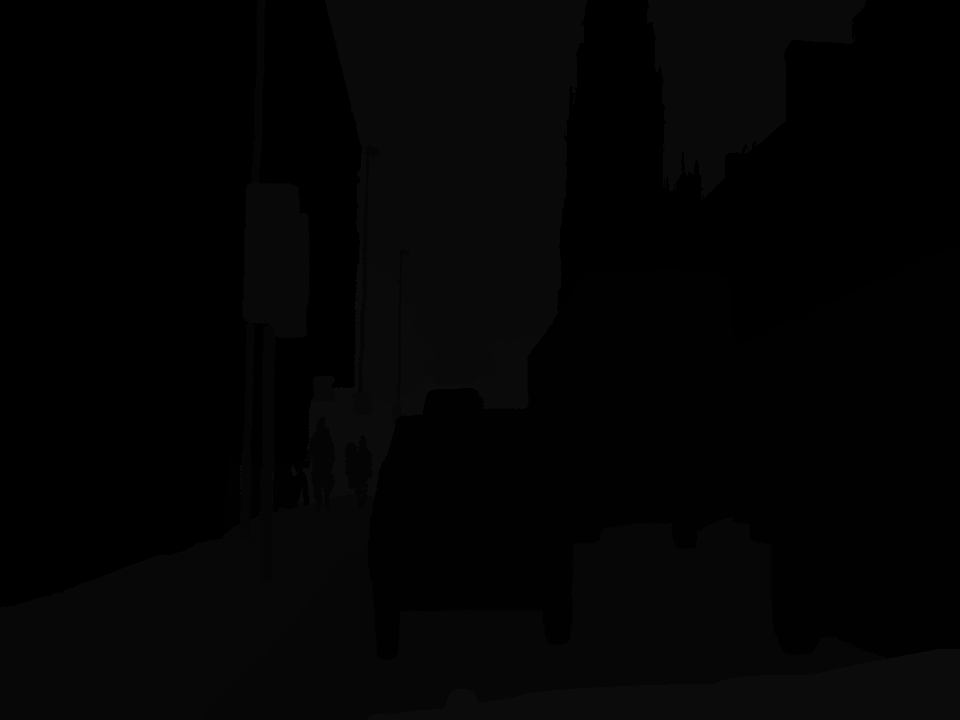

In [11]:
lbl1_fp = lbl_fp[0]
lbl1 = open_im(lbl1_fp); lbl1

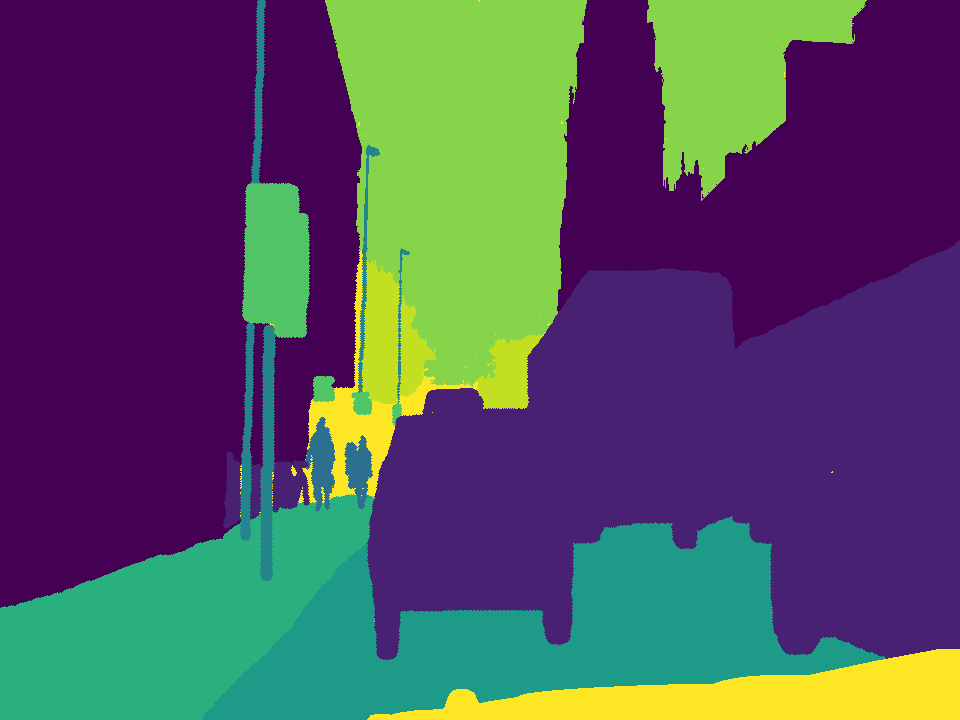

In [13]:
open_mask(lbl1_fp)

## DataBunch

In [53]:
new_codes = ['Building', 'Car', 'Cyclist', 'Fence', 'Pedestrian', 'Pole', 'Road', 'Sidewalk', 
             'Sign', 'Sky', 'Vegetation', 'Void']

In [54]:
lbl1_data = np.array(lbl1)

In [55]:
src_size = np.array(lbl1_data.shape); src_size

array([720, 960])

In [32]:
def get_data(size, bs):
    return (SegmentationItemList.from_folder(image_path)
            .split_by_fname_file(valid_path)
            .label_from_func(get_lbl_fp, classes=new_codes)
            .transform(get_transforms(),size=size,tfm_y=True)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

## Viewing Data

In [45]:
data = get_data(src_size//2,4)

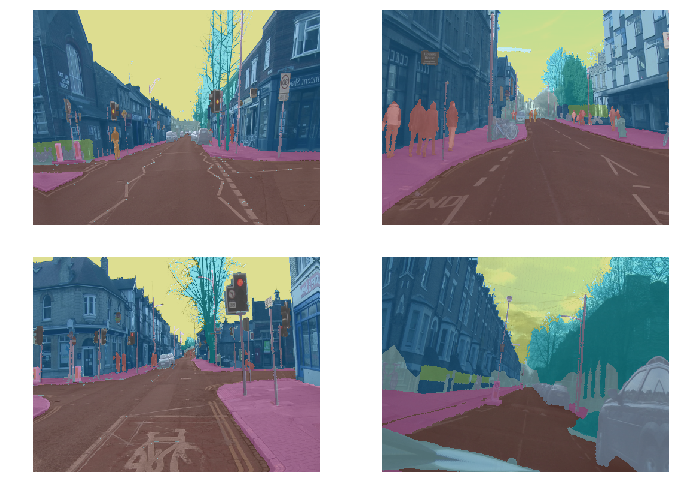

In [46]:
data.show_batch(2,figsize=(10,7))

## Augmentation

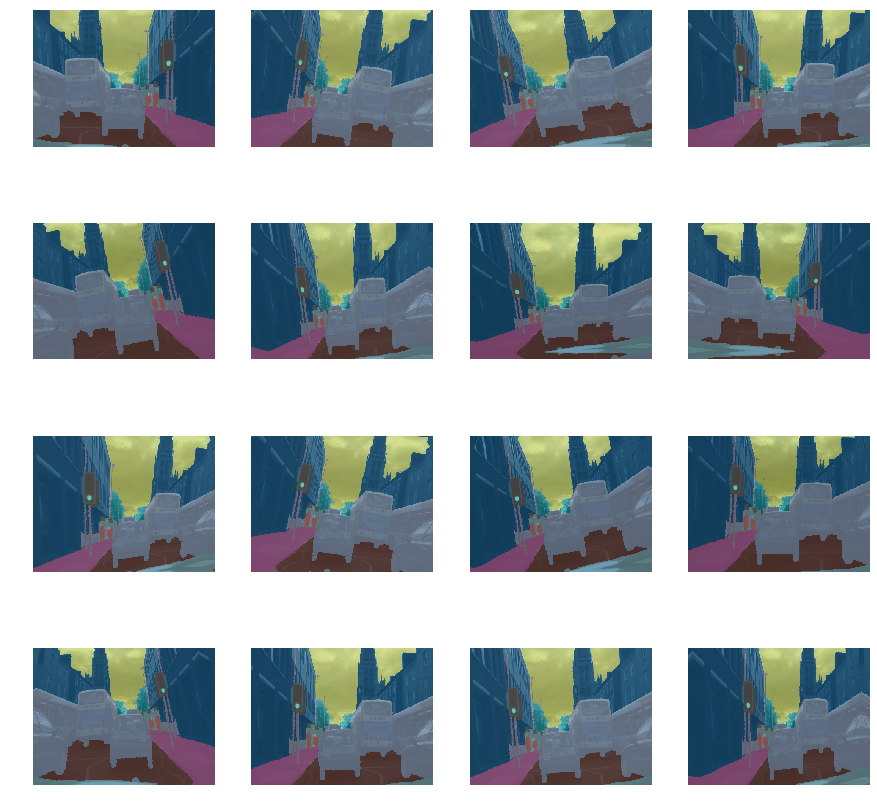

In [38]:
def plot(i,j,ax,idx=0):
    x,y = data.train_ds[idx]
    x.show(ax,y=y)
plot_multi(plot,4,4,figsize=(15,15))

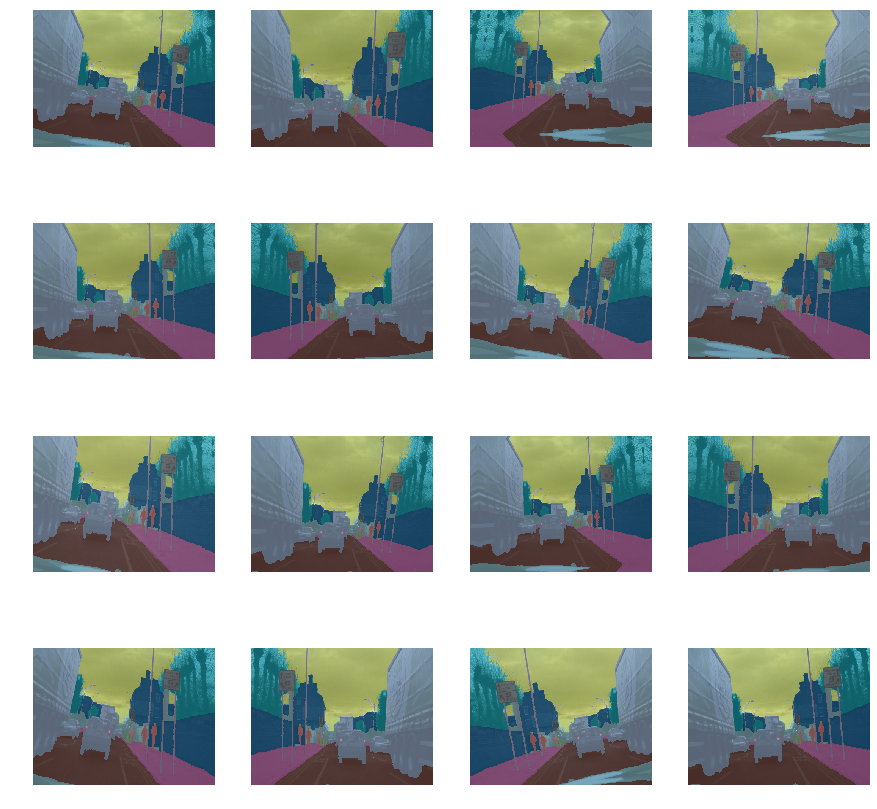

In [39]:
def plot(i,j,ax):
    x,y = data.train_ds[100]
    x.show(ax,y=y)
plot_multi(plot,4,4,figsize=(15,15))

In [40]:
gc.collect()

27256

# Metrics

In [41]:
name2id = {v:k for k,v in enumerate(new_codes)}
void_code = name2id['Void']

In [42]:
def acc_camvid(input,target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

# Model

## Train 1

In [30]:
data = get_data(src_size,2)

In [31]:
learn1 = unet_learner(data, models.resnet34, metrics=acc_camvid,
                     wd=1e-1, bottle=True, path='D:/projects/camvid/',
                    callback_fns=[partial(SaveModelCallback,every='epoch',name='1'),
                                 ShowGraph])

In [32]:
learn1.unfreeze()

In [33]:
learn1.to_fp16();

epoch,train_loss,valid_loss,acc_camvid
1,0.644453,0.617165,0.831902
2,0.491831,0.462060,0.880219
3,0.439749,0.339088,0.902313
4,0.435628,0.317120,0.905431
5,0.354627,0.271732,0.915617
6,0.336646,0.320932,0.898140
7,0.330919,0.285501,0.915782
8,0.316811,0.300362,0.917910
9,0.276692,0.268444,0.921380
10,0.294425,0.336030,0.916155


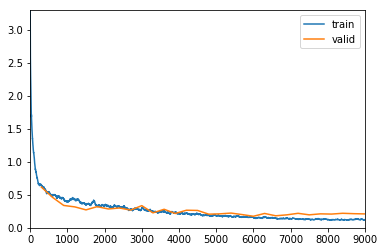

In [34]:
learn1.fit_one_cycle(30, slice(1e-6,1e-3))

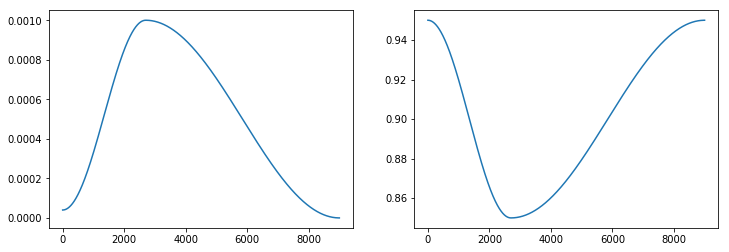

In [37]:
learn1.recorder.plot_lr(show_moms=True)

# Results

In [30]:
data = get_data(src_size,2)

In [31]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid,
                     wd=1e-3, bottle=True, path='D:/programming/projects/camvid/',
                    callback_fns=[partial(SaveModelCallback,every='epoch',name='3'),
                                 ShowGraph])

In [32]:
learn.load(weights/'1_24');

In [38]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [2, 64, 360, 480]    9408       False     
______________________________________________________________________
BatchNorm2d          [2, 64, 360, 480]    128        True      
______________________________________________________________________
ReLU                 [2, 64, 360, 480]    0          False     
______________________________________________________________________
MaxPool2d            [2, 64, 180, 240]    0          False     
______________________________________________________________________
Conv2d               [2, 64, 180, 240]    36864      False     
______________________________________________________________________
BatchNorm2d          [2, 64, 180, 240]    128        True      
______________________________________________________________________
ReLU                 [2, 64, 180, 240]    0          False     
______________________________________________________________

______________________________________________________________________
ReplicationPad2d     [2, 192, 181, 241]   0          False     
______________________________________________________________________
AvgPool2d            [2, 192, 180, 240]   0          False     
______________________________________________________________________
ReLU                 [2, 768, 90, 120]    0          False     
______________________________________________________________________
BatchNorm2d          [2, 64, 180, 240]    128        True      
______________________________________________________________________
Conv2d               [2, 256, 180, 240]   590080     True      
______________________________________________________________________
ReLU                 [2, 256, 180, 240]   0          False     
______________________________________________________________________
Conv2d               [2, 256, 180, 240]   590080     True      
_______________________________________________________

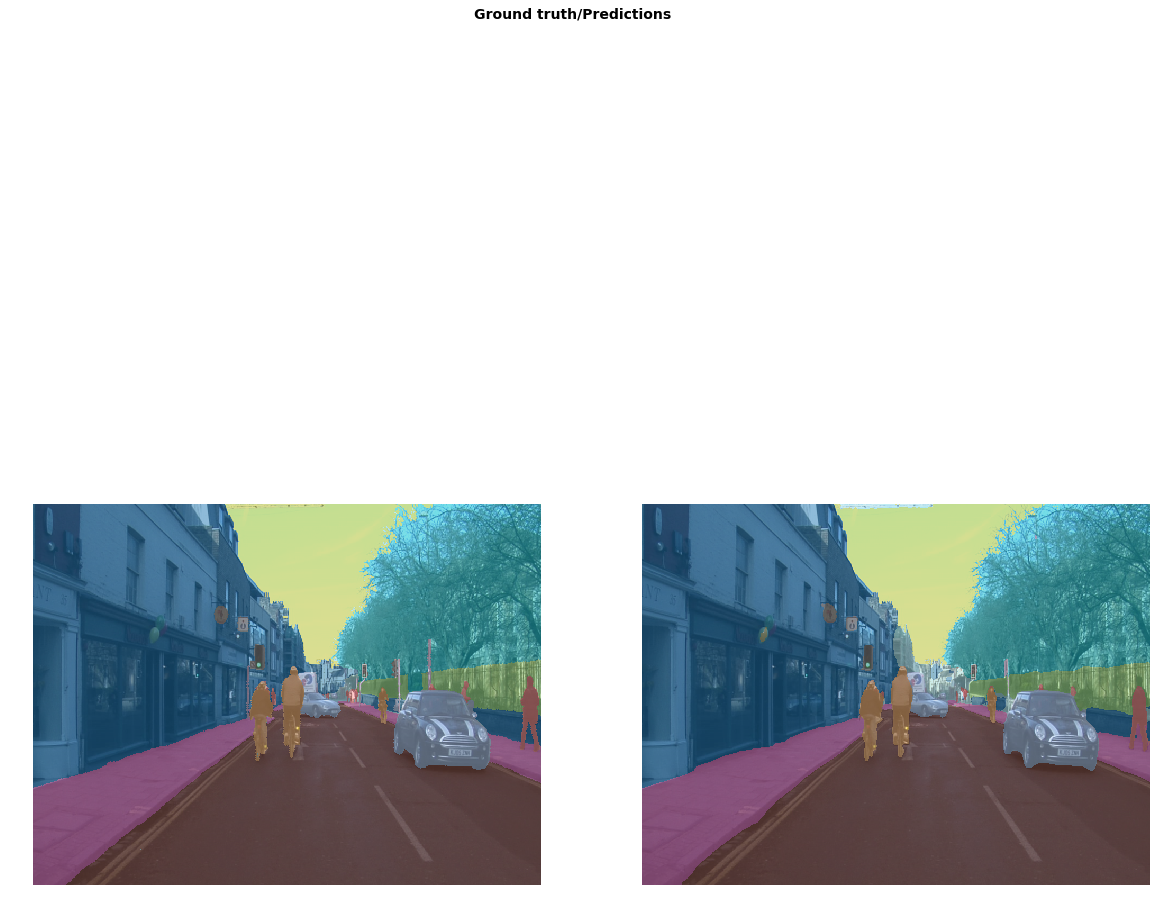

In [35]:
learn.show_results(rows=1,figsize=(20,20))

# End